### torch.dataset() and torch.dataloader()
- són 2 components de torch. 
- podem fer inferencia aprofitant el màxim rendiment a la gpu.
- la gpu la forma que te de operar contra les matrius està pensada per optimizar i paral·lelitzar al màxim en base dels mini cores que té. 

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as prf

In [3]:
from PIL import Image, ExifTags, ImageOps, ImageDraw
from src import bbox2tlbr, sqrbbox, compute_IoU

In [4]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

- la novetat està en: **`from torch.utils.data import Dataset, DataLoader`**
- dataset és un objecte, una classe que està a torch que aquí l'estem customitzant, hi han variants d'aquest dataset pre-programats, a torch, que ens permeten accedir a les nostres dades (en aquests cas imatges, corpus de text, audio, etc). És una abstracció d'això pensada per treballar amb el dataloader.
    - Aquesta classe ha de tenir dos metodes: len i getitem
- hi ha un altre objecte que si tenim les fotos en carpetes per classes (imagtes > albopictus / tots els mosquits)
- una carpeta per cada classe
- en aquest cas, no tenim un fitxer .csv que estem especificant cada etiqueta, sino que ho diu a la carpeta. 
- dataset from folder **dataset** organitzat amb carpetes i aquestes diuen el nom de la classe. Aquesta classe ja sap com anar-ho a buscar.
- És millor no fer-ho amb folders.
    - tot en una carpeta i tens un fitxer que et diu cada cosa que es. 

### create custom dataset

In [5]:
_imgRoot = '../mosquits/phase2_test/test/final/'
_classes = ['aegypti', 'albopictus', 'anopheles', 'culex', 'culiseta', 'japonicus-koreicus', '??']
_imgSize = 512 # pretrained at 384
_imgNorm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# control image max-size 
Image.MAX_IMAGE_PIXELS = 201326592
Image.warnings.simplefilter('error', Image.DecompressionBombWarning)

In [6]:
class maDataset(Dataset):
    
    def __init__(self, csvDataFile):
        # llegir les imatges
        self.df = pd.read_csv(csvDataFile)
        
        # Quines transformacions els hi volem fer a les imatges
        self.transform = transforms.Compose([
                transforms.Resize((_imgSize, _imgSize)),
                transforms.ToTensor(),
                transforms.Normalize(_imgNorm[0], _imgNorm[1])
            ])
    
    # Torna la llargada, quants items tenim (imatges, text ...)
    def __len__(self):
        return len(self.df)
    
    # El que ha de fer és: explicat a baix.
    def __getitem__(self, idx):
    
        # open image file
        row = self.df.iloc[idx]
        pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
        # crop image
        bbox = sqrbbox([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], pilImg.size)
        pilImg = pilImg.crop(bbox)
        # transform to torch tensor image
        torchImg = self.transform(pilImg)

        return {'img_fName': row.img_fName, 'image' : torchImg, 'label': row.class_label}
 

- els metodes els fa servir el dataloader. 
- invoca len per saber de que estem tractant, i el getitem per agafar-ne un. 
- get item, torna un diccionari. 

In [7]:
# instantiate our custom dataset
csvDataFile = '../mosquits/phase2_test.csv'
_maDataset = maDataset(csvDataFile)
_maDataset.__len__()

2763

In [20]:
_dataLoader = DataLoader(_maDataset, batch_size = 4, shuffle = False, num_workers = 4)

In [22]:
batch = next(iter(_dataLoader))

- torna les 4 imatges perque el batch size es 4. 
- la estructura que torna: nom, tensor (imatge un cop fet el crop i transformació) i una etiqueta. 
- és un diccionari amb tantes claus com hem defiit a la classe inicial.

In [23]:
[key for key in batch.keys()]

['img_fName', 'image', 'label']

- el dataloader ha empaquetat:

In [24]:
batch['img_fName']

['test_00000.jpeg', 'test_00001.jpeg', 'test_00002.jpeg', 'test_00003.jpeg']

- Llista amb els noms dels fitxers que ha agafat

In [27]:
batch['image'].size()

torch.Size([4, 3, 512, 512])

- això és el tensor amb el shape, 1 numero afegit, 3 nose, 512 px alt i height

In [25]:
batch['image']

tensor([[[[ 1.4098,  1.4098,  1.4098,  ...,  1.2043,  1.2043,  1.2043],
          [ 1.4098,  1.4098,  1.4098,  ...,  1.1872,  1.2043,  1.2043],
          [ 1.3927,  1.3927,  1.4098,  ...,  1.1700,  1.1872,  1.2043],
          ...,
          [-0.6281, -0.6452, -0.6794,  ..., -0.7137, -0.6965, -0.6965],
          [-0.6109, -0.6281, -0.6623,  ..., -0.7308, -0.7137, -0.7137],
          [-0.6109, -0.6109, -0.6281,  ..., -0.7308, -0.7137, -0.6965]],

         [[ 1.6583,  1.6583,  1.6583,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.6583,  1.6583,  1.6583,  ...,  1.4832,  1.5007,  1.5007],
          [ 1.6408,  1.6408,  1.6583,  ...,  1.4657,  1.4832,  1.5007],
          ...,
          [-0.8978, -0.9153, -0.9503,  ..., -0.9328, -0.9153, -0.9153],
          [-0.8803, -0.8978, -0.9153,  ..., -0.9503, -0.9328, -0.9328],
          [-0.8627, -0.8627, -0.8803,  ..., -0.9503, -0.9328, -0.9153]],

         [[ 1.9428,  1.9428,  1.9428,  ...,  1.7685,  1.7685,  1.7685],
          [ 1.9428,  1.9428,  

- És un tensor, amb shape **torch.Size([4, 3, 512, 512])**
    - les hem normalitzat amb els valors de _imgNorm
    - 

- dataloader, en funció de batchsize i loaders, per tenir tants fils operant en paral·lel per obrir el nº de imatges que volem
- batch size i num workers no ha de ser igual
- 16 imatges i 4 workers. Si tenim una màquina amb 8 cpu, si posem 6 per deixar els altres que vagin fent. 
- workers són fils
- ---
- batch size optim o màxim
- en funció de la ram de la gpu, li passarem ael tensor, hi ha de cabre a la memòria.
- Si tenim 80gb de memòria, si tenim imatges de 256x256 ens n'entren 200/500, ens interessa no tenir el batch size massa gran perque el backpropagation es pugui fer bé. 
- L'error es promitja per tot el bach (16 imatges calculades) backpropagation del promig d'aquestes 16 errors.
- si propagem una a una no apren perque els errors son molts diferents
- si es un promig és millor. la actualització dels parametres es mes conservadora.
- això es el compromís del batch size
    - primer per la ram
    - temps d'entrenament
    - rendiment que esperem (no overfitting, que el model convergeixi cap a algo que hagi aprés)
    - batch size masa petit i no apren
    - batch size masa gran, és soroll blanc, sempre dona el mateix promig i la xarxa no apren res. 

In [29]:
batch['label']

['culex', 'culex', 'japonicus-koreicus', 'japonicus-koreicus']

- volem predir això
- ---
- li donarem a la xarxa la imatge i la etiqueta, fem la inferencia, veure error i això és el que propagarem.

In [30]:
del(_dataLoader)

### batch prediction

In [8]:
def batch_inference(batch_size = 8, num_workers = 8):

    _device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # instantiate the dataloader
    _dataLoader = DataLoader(_maDataset, batch_size = batch_size, shuffle = False, num_workers = num_workers)
    
    # load the model
    model = torch.load('../mosquits/cnn_mosquits/stage1/classifier.pth').to(_device)
    model.eval()
    
    # make inference
    predict = []
    with torch.no_grad():
        for iBatch in _dataLoader:
            try:
                inputs = iBatch['image'].to(_device)
                output = model(inputs)
                output = torch.nn.functional.softmax(output, dim = 1)
                scores = output.cpu().detach().numpy()
                for img_fName, score in zip(iBatch['img_fName'], scores):
                    label = _classes[np.argmax(score)]
                    predict.append({'img_fName': img_fName, 'scores': score, 'pred_label': label})
            except BaseException as err:
                print(f"+++ batch_inference() {type(err).__name__}, {err}")
                raise
    
    return predict

- Fem una instancia de _dataLoader que li passem el Dataset customitzat és _maDataset
- num_workers = threads workers en paral·lel
- shuffle: si les barreja o no. Està a false perquè no estem entrenant. True quan estem entrenant. 
- ---
- Demanem al dataloader que ens doni lots/batch. Ell s'organitza. Si tenim 4 workers, i a cada 1 li donarà un index d'una imatge que ha d'anar a buscar i executarà el get item d'aquella imatge i cada un dels threads la procesarà i li donarà al dataloader i ell ho empaquetarà en aquell batch. 
- El parametre de **shuffle** barreja
    - si està a false: el dataloader anirà demanant i enviant, els index que anira enviant són correlatius
    - si està a true: encomptes de tornar 0,1,2,3, torna random
    - quan estem entrenant, no ens interesa, a cada epoch, amb 1 epoch a tornat tots els possibles batchos. 
    - així els batches són diferents, no s'organitzen de forma ordenada. 
    - a cada epoch aquest shuffeling es diferent
    - a cada passada passen amb ordre diferent, no condicionem la actualització d'actualització.
    - també els batch no sigui sempre els mateixos.
    - forma de fer aleatoria la presentació de les dades a la xarxa.
- ---
- posar el model amb mode eval, si el volem entrenar, el posem en  mode train.
- llista per guardar prediccions.
- el **with torch.no_grad():**
    - el detach del tensor (lu que té més atributs) un d'aquests atributs són els gradients que es fan servir per calcular els pesos al back. Si incorporem els gradients, ocupa més, com que no hem de fer backpropagation. aquest encapsulament el que farà, que els tensors d'allà dins no tinguin gradients (per estalviar memòria). Per train si. 
    - Fem la inferència. anem iterant sobre el dataloader perque doni batch
    - **iBatch['image']**, ho pasem a la gpu i tot el tensor el passem al model. 
    - podem fer inferencia sobre tot el lot a la vegada. 
    - abans output era un tensor que era un logit per cada classe.
    - ara serà un tensor amb una dimensio més, tenim aquests logits per cada imatge del batch
    - imatge 1 aquests logits
    - imatge 2 aquests logits
    - el output el passem a cpu (com al notebook anterior)
- ens interesa guardar els scores
    - noms de imatges, que ja hem inclos en els items que té el batch
    - mira quin és el maxim, el que té més probabilitat
    - nom foto, soft prediction i hard prediction (això és el que retorna). una llista d'això. 

In [32]:
%%time
batch_size, num_workers = 8, 8
predict = pd.DataFrame(batch_inference(batch_size = batch_size, num_workers = num_workers))
predict.head()

CPU times: user 1min 18s, sys: 955 ms, total: 1min 19s
Wall time: 1min 19s


,img_fName,scores,pred_label
0,test_00000.jpeg,"[0.01528146, 0.01979054, 0.0145556955, 0.90558...",culex
1,test_00001.jpeg,"[0.013890062, 0.017157914, 0.014496301, 0.9102...",culex
2,test_00002.jpeg,"[0.019446522, 0.020252015, 0.015587696, 0.0226...",japonicus-koreicus
3,test_00003.jpeg,"[0.016405242, 0.021240188, 0.014887984, 0.0198...",japonicus-koreicus
4,test_00004.jpeg,"[0.016250247, 0.019632127, 0.01542298, 0.89825...",culex


- prediccions de 8 en 8. un fil per cada un
- el resultat (la llista de diccionaris) ho converteix a dataframe
- ara la gpu treballa més
- si s'hagues d'esperar a un nou batch, faria oscil·lacions

In [10]:
df_ = pd.merge(_maDataset.df, predict, how = 'inner', on = 'img_fName')
df_.head()

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label,scores,pred_label
0,test_00000.jpeg,4032,1908,711.0,378.0,1721.0,1367.0,culex,"[0.01528146, 0.01979054, 0.0145556955, 0.90558...",culex
1,test_00001.jpeg,1997,1831,853.0,412.0,1364.0,1085.0,culex,"[0.013890062, 0.017157914, 0.014496301, 0.9102...",culex
2,test_00002.jpeg,4160,3120,20.0,145.0,3049.0,4160.0,japonicus-koreicus,"[0.019446522, 0.020252015, 0.015587696, 0.0226...",japonicus-koreicus
3,test_00003.jpeg,4000,3000,68.0,54.0,3695.0,2376.0,japonicus-koreicus,"[0.016405242, 0.021240188, 0.014887984, 0.0198...",japonicus-koreicus
4,test_00004.jpeg,1600,1200,719.0,400.0,1045.0,745.0,culex,"[0.016250247, 0.019632127, 0.01542298, 0.89825...",culex


In [11]:
df_.groupby('class_label').pred_label.value_counts()

class_label         pred_label        
aegypti             aegypti                  7
                    albopictus               1
                    culex                    1
                    culiseta                 1
albopictus          albopictus            1169
                    ??                      12
                    japonicus-koreicus       8
                    culex                    6
                    aegypti                  5
                    culiseta                 2
anopheles           anopheles               27
                    culex                    3
                    culiseta                 3
culex               culex                 1102
                    culiseta                10
                    ??                       9
                    anopheles                4
                    aegypti                  1
                    albopictus               1
culiseta            culiseta               141
                    c

#### Classification

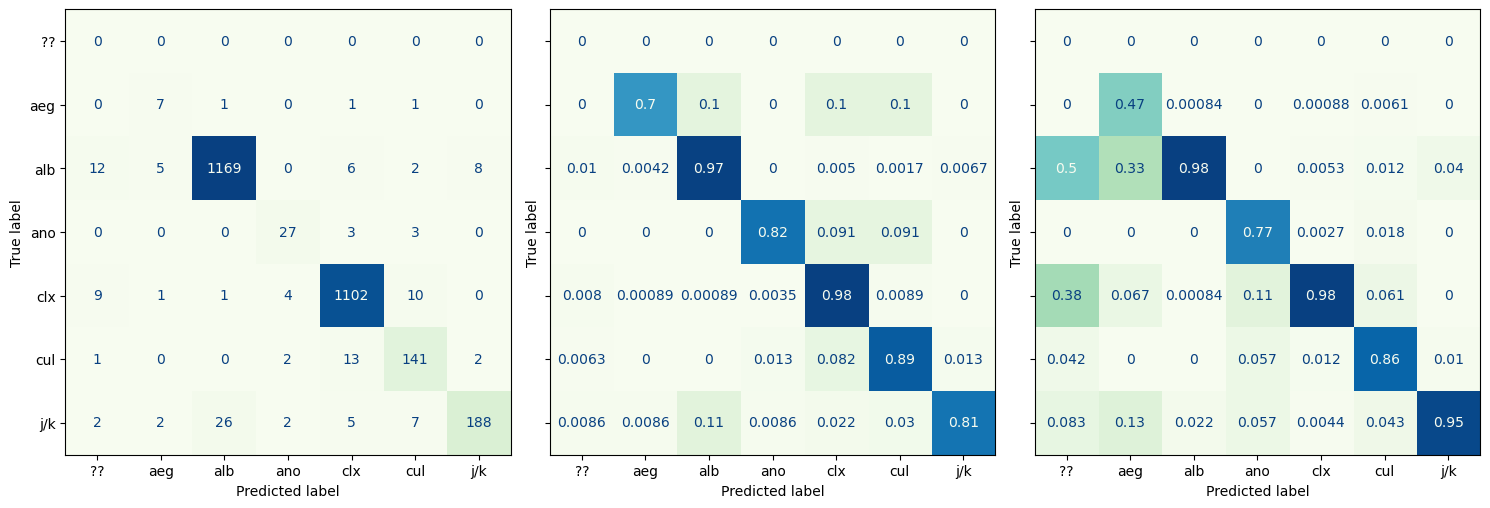

In [12]:
_, axs = plt.subplots(1, 3, figsize = (15, 7), sharey = True)
for i, norm in enumerate([None, 'true', 'pred']):
    ConfusionMatrixDisplay.from_predictions(
        df_.class_label,
        df_.pred_label,
        normalize = norm,
        ax = axs[i],
        display_labels = ['??', 'aeg', 'alb', 'ano', 'clx', 'cul', 'j/k'],
        cmap = 'GnBu',
        colorbar = None
    )
plt.tight_layout()

In [13]:
avrgs = ['macro', 'micro', 'weighted']
pd.DataFrame([prf(df_.class_label, df_.pred_label, average = mode, zero_division = 0)[:3] for mode in avrgs], columns = ['precision', 'recall', 'f-score'], index = avrgs)

,precision,recall,f-score
macro,0.714168,0.737955,0.721813
micro,0.953312,0.953312,0.953312
weighted,0.962745,0.953312,0.957459


- macro: cada classe pesa el mateix, una de 17 exemples pesa el mateix que una de 1000 albopictus. cada classe n mostres.
- micro: cuants bé i quants malament independent de la classe.
- weighted: macro però en funció de quants n'hi ha de cada classe.
- --- 
- la diferencia entre macro i weighted, tu com a modelador, tens una opció que es donar la etiqueta a la classe majoritaria. si aquest desbalançeig.
    - 95 exemples de una classe
    - 5 d'un altre
- si sempre clase 1 95%.
- ---
- Aquí amb el weighted estem tinguent amb compte que de un n'hi ha més que dels altres. 
- ---
- Quina mesura agafem si hem de vendre el model: 
- el model acerta el 95% o acerta el 71%
- Si el vols vendre amb una clausula el 71%
- Si realment poguessis assegurar que te'n vindrien molts menys, podríem dir que si que es el 95%

#### check predictions

In [14]:
i = -1

+++  0 test_00000.jpeg - culex / culex


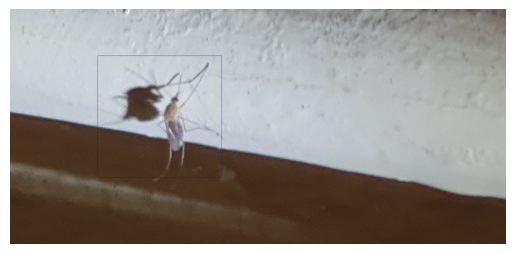

In [15]:
i += 1
row = df_.iloc[i]
pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
imgdrw = ImageDraw.Draw(pilImg)
imgdrw.rectangle([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], outline = 'blue', width = 2)
plt.imshow(pilImg)
plt.axis('off');
print('+++%3d %s - %s / %s' %(i, row.img_fName, row.class_label, row.pred_label))

In [16]:
chk = df_[df_.pred_label == '??']
len(chk)

24

In [17]:
j = -1

+++  0 - albopictus / ??


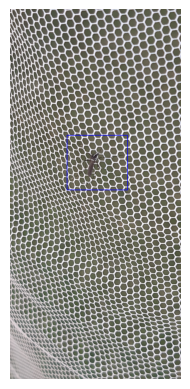

In [18]:
j += 1
row = chk.iloc[j]
pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
imgdrw = ImageDraw.Draw(pilImg)
imgdrw.rectangle([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], outline = 'blue', width = 8)
plt.imshow(pilImg)
plt.axis('off');
print('+++%3d - %s / %s' %(i, row.class_label, row.pred_label))

- si fem una convolució sobre això, algo que trenca el patró, el mosquit no té prou força. 
- ?? en aquesta arquitectura, que hi havia al final? hi havia, el classificador, que era una capa amb tantes classes com neurones hi ha. si hi ha 7 nivells d'activació hi ha 7 classes. Els 6 primers són les classes que hi ha. La persona quan va afegir imatges sense mosquit. 